# v831 部署 Sobel 卷积边缘检测

边缘就是值变化剧烈的地方, 如果对值的变化求导, 则边缘部分就是导数局部最大。

但是在图像处理时没有具体的函数让我们求导, 使用卷积运算则可以很好的近似替代。

卷积运算是神经网络的最常用的基本运算，所以非常适合用来展示神经网络在 v831 上的部署过程。

## 边缘检测效果

![](https://neucrack.com/image/1/377/test.jpg)
![](https://neucrack.com/image/1/377/sobel_edge2.jpg)
![](https://neucrack.com/image/1/377/final.jpg)
![](https://neucrack.com/image/1/377/sobel_edge.jpg)
![](https://neucrack.com/image/1/377/sobel_v831.jpg)
![](./sobel.jpg)

## 卷积边缘检测原理

如下图, 假设左上为坐标原点, 横轴为 x, 纵轴为y, 如下图左上角9个像素点, P(x, y)表示坐标(x, y)的点, 要求P(1, 1)处在x轴的变化率, 则只需将P(2, 1) - P(0, 1) 得到值为0, P(1, 0)处为1-3 = -2, 这个差值即变化率, 类比成导数, 我们就能知道横轴在哪些地方变化率更大.

![](https://neucrack.com/image/1/377/conv.jpg)

上面这种方法我们可以得到横轴的变化率, 这里使用卷积核

~~~ python
[-1, 0, 1],
[-2, 0, 2],
[-1, 0, 1]
~~~

对图像进行卷积运算, 如图中的计算方法, 像素点左右权值取2, 角上的也参与计算,但是权值为1,没有左右边的权值高. 这样我们就得到了横轴的变化率图, 即边缘检测图.

注意, 这里是对横轴计算了, 比较的点左右的值变化, 所以实际看到的图像会出现明显的纵轴边缘, 如下图左边

![](https://neucrack.com/image/1/377/vertical_horizontal.jpg)

同理, 上图右边的图使用卷积核

[1,2,1],
[0,0,0],
[-1, -2, -1]
得到的纵轴的边缘图.

注意这里用右边减左边, 如果右边的值比左边的小会是负数, 如果我们希望只检测颜色值变大(变白)则可以直接使用, 如果两个变化方向都要检测, 则可以取绝对值. 比如下图左边是没有取绝对值, 右边取了绝对值
![](https://neucrack.com/image/1/377/without_with_abs.jpg)
得到两个方向的图后, 对其进行合并, 对每个像素平方和开方即可
![](https://neucrack.com/image/1/377/final.jpg)
这张图左边是使用 GIMP 的 sobel 边缘检测(垂直+水平)的效果, 略微有点不同:
![](https://neucrack.com/image/1/377/sobel_edge2.jpg)
不同的原因是使用水平和垂直的图平方和开根后, 直接用 `plt.imshow` 显示, 和 GIMP 的处理方式不同
```python
out = np.sqrt(np.square(out_v) + np.square(out_h))
plt.imshow(out)
```
简单地直接将值规范到`[0, 255]`就和 GIMP 的图相似了(但不完全一样)
```python
out = np.sqrt(np.square(out_v) + np.square(out_h))
out = out * 255.0 / out.max()
plt.imshow(out.astype(np.uint8))
```
![](https://neucrack.com/image/1/377/sobel_v_h.jpg)

## 自定义卷积核来实现边缘检测

除了上面说了使用两次卷积计算, 也可以用只计算一次的卷积核, 比如:
```bash
[-1, -1, -1],
[ -1, 8, -1],
[ -1, -1, -1]
```
这是对于一个通道(灰度图)来说, 如果要扩充到三个通道(RGB), 卷积核参数就是如下形式
```bash
conv_rgb_core_sobel = [
                        [[-1,-1,-1],[-1,8,-1], [-1,    -1,    -1],
                         [0,0,0],[0,0,0], [0,0,0],
                         [0,0,0],[0,0,0], [0,0,0]
                        ],
                        [[0,0,0],[0,0,0], [0,0,0],
                         [-1,-1,-1],[-1,8,-1], [-1,    -1,    -1],
                         [0,0,0],[0,0,0], [0,0,0]
                        ],
                        [[0,0,0],[0,0,0], [0,0,0],
                         [0,0,0],[0,0,0], [0,0,0],
                         [-1,-1,-1],[-1,8,-1], [-1,    -1,    -1],
                        ]]
```
经过卷积运算后, 前后图如下:

![](https://neucrack.com/image/1/377/sobel_edge.jpg)

注意, 输入值范围如果为`[0, 255]`, 输出值则范围会变化, 以图片形式查看时需要注意加以处理, 这里使用了`plt.imshow(out)`来显示, 这个函数会自动对图像做简单的处理, 才会看起来是黑色背景

## 导出成模型使用
可以将 Net 导出成 onnx 即可在其它平台使用, 就是一个简单的卷积层

部署到 V831 后的样子(使用了卷积核`[-1,-1,-1],[-1,8,-1], [-1,-1,-1],`):

![](https://neucrack.com/image/1/377/sobel_v831.jpg)

V831 部署[源码](https://github.com/sipeed/MaixPy3/blob/master/ext_modules/_maix_nn/example/load_forward_sobel_edge_camera.py)在 github， 模型在 maixhub 上可以下载

## 边缘检测源码

> 这是在电脑上运行的代码，不是在开发板平台上运行的代码





In [1]:
'''
    simple sobel edge demo
    visit: https://neucrack.com/p/377
    @author neucrack
    @license MIT
'''
# 引入模块
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


In [2]:
# 定义一个网络模型
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 3, 3, padding=(0, 0), bias=False)
    def forward(self, x):
        x = self.conv1(x)
        return x
net = Net()


In [3]:
# 定义卷积权重
# sobel全边缘检测算子
conv_rgb_core_sobel = [
                        [[-1,-1,-1],[-1,8,-1], [-1,    -1,    -1],
                         [0,0,0],[0,0,0], [0,0,0],
                         [0,0,0],[0,0,0], [0,0,0]
                        ],
                        [[0,0,0],[0,0,0], [0,0,0],
                         [-1,-1,-1],[-1,8,-1], [-1,    -1,    -1],
                         [0,0,0],[0,0,0], [0,0,0]
                        ],
                        [[0,0,0],[0,0,0], [0,0,0],
                         [0,0,0],[0,0,0], [0,0,0],
                         [-1,-1,-1],[-1,8,-1], [-1,    -1,    -1],
                        ]]

# sobel垂直边缘检测算子
conv_rgb_core_sobel_vertical = [
                        [[-1,0,1],[-2,0,2], [-1,    0,    1],
                         [0,0,0],[0,0,0], [0,0,0],
                         [0,0,0],[0,0,0], [0,0,0]
                        ],
                        [[0,0,0],[0,0,0], [0,0,0],
                         [-1,0,1],[-2,0,2], [-1,    0,    1],
                         [0,0,0],[0,0,0], [0,0,0]
                        ],
                        [[0,0,0],[0,0,0], [0,0,0],
                         [0,0,0],[0,0,0], [0,0,0],
                         [-1,0,1],[-2,0,2], [-1,    0,    1],
                        ]]

# sobel水平边缘检测算子
conv_rgb_core_sobel_horizontal = [
                        [[1,2,1],[0,0,0], [-1, -2, -1],
                         [0,0,0],[0,0,0], [0,0,0],
                         [0,0,0],[0,0,0], [0,0,0]
                        ],
                        [[0,0,0],[0,0,0], [0,0,0],
                         [1,2,1],[0,0,0], [-1, -2, -1],
                         [0,0,0],[0,0,0], [0,0,0]
                        ],
                        [[0,0,0],[0,0,0], [0,0,0],
                         [0,0,0],[0,0,0], [0,0,0],
                         [1,2,1],[0,0,0], [-1, -2, -1],
                        ]]



In [4]:
# 网络载入权重函数
def sobel(net, kernel):
    sobel_kernel = np.array(kernel,    dtype='float32')
    sobel_kernel = sobel_kernel.reshape((3,    3,    3,    3))
    net.conv1.weight.data = torch.from_numpy(sobel_kernel)
params = list(net.parameters())

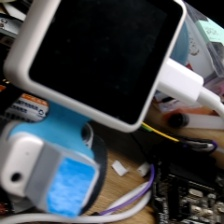

(224, 224, 3)


In [6]:
# 打开一张图片
pil_img = Image.open("./images/class1_5.jpg")
display(pil_img)
input_img = np.array(pil_img)
print(input_img.shape)


In [7]:
# 图片归一化处理
input_tensor = (input_img.astype(np.float32) - 127.5) / 128 # to [-1, 1]

print(input_tensor.shape)

input_tensor = torch.Tensor(input_tensor).permute((2, 0, 1))

input_tensor = input_tensor.unsqueeze(0)

print("input shape:", input_tensor.shape)


(224, 224, 3)
input shape: torch.Size([1, 3, 224, 224])


In [8]:
# 将入片转换成 pytorch 张量
input_tensor = (input_img.astype(np.float32) - 127.5) / 128 # to [-1, 1]
input_tensor = torch.Tensor(input_tensor).permute((2, 0, 1))
print(input_tensor.shape)
input_tensor = input_tensor.unsqueeze(0)
print("input shape:", input_tensor.shape)


torch.Size([3, 224, 224])
input shape: torch.Size([1, 3, 224, 224])


In [9]:

global sobel_img 
global sobel_vertical_img
global sobel_horizontal_img 



sobel_img = None
sobel_vertical_img = None
sobel_horizontal_img = None

#载入网络权重
sobel(net, conv_rgb_core_sobel_vertical)
#在推理模式下运行网络
with torch.no_grad():
    out = net(input_tensor)
    
    sobel_vertical_img_t = out.numpy()[0].transpose([1,2,0])

    

#载入网络权重
sobel(net, conv_rgb_core_sobel_horizontal)
#在推理模式下运行网络
with torch.no_grad():
    out = net(input_tensor)
    
    sobel_horizontal_img_t = out.numpy()[0].transpose([1,2,0])

    
#载入网络权重
sobel(net, conv_rgb_core_sobel)
#在推理模式下运行网络
with torch.no_grad():
    out = net(input_tensor)
    
    sobel_img_t = out.numpy()[0].transpose([1,2,0])




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

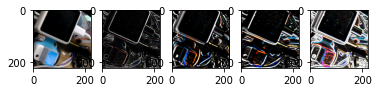

In [10]:
plt.figure()
plt.figure()
plt.subplot(1, 5, 1)
plt.imshow(input_img)
plt.subplot(1, 5, 2)
plt.imshow(sobel_img_t)
plt.subplot(1, 5, 3)
plt.imshow(sobel_vertical_img_t)
plt.subplot(1, 5, 4)
plt.imshow(sobel_horizontal_img_t)
plt.subplot(1, 5, 5)
out = np.sqrt(np.square(sobel_vertical_img_t) + np.square(sobel_horizontal_img_t))
plt.imshow(out)
plt.show()

In [11]:
# 导出onnx网络
with torch.no_grad():
    torch.onnx.export(net, input_tensor, "./model.onnx", export_params=True, input_names = ["input0"], output_names=["output0"])
    print("导出网络完成！")

导出网络完成！


In [12]:
# 使用ncnn 工具将 onnx 网络转换成 ncnn网络
def onnx_to_ncnn(input_shape, onnx="out/model.onnx", ncnn_param="out/conv0.param", ncnn_bin = "out/conv0.bin"):
    import os
    # onnx2ncnn tool compiled from ncnn/tools/onnx, and in the buld dir
    cmd = f"onnx2ncnn {onnx} {ncnn_param} {ncnn_bin}"       #可以更换工具目录
    os.system(cmd)
    with open(ncnn_param) as f:
        content = f.read().split("\n")
        if len(input_shape) == 1:
            content[2] += " 0={}".format(input_shape[0])
        else:
            content[2] += " 0={} 1={} 2={}".format(input_shape[2], input_shape[1], input_shape[0])
        content = "\n".join(content)
    with open(ncnn_param, "w") as f:
        f.write(content)

onnx_to_ncnn(input_shape = (3, 224, 224), onnx = "./model.onnx", ncnn_param="./conv0.param", ncnn_bin = "./conv0.bin")
print("net success!")
        

net success!


## 使用在线量化工具进行网络量化！

### 模型转换  

在线转换需要上传一个压缩包文件.  
- 该功能只能支持上传一个无密码的 zip 压缩包  
- 压缩包内需要包含一个 images 目录，一个 xxx.bin，一个 xxx.param  
- 需要将矫正图片放入 images 目录内；矫正图片集可考虑直接采用训练中的验证数据集，并务必保证矫正时图像的预处理方式与训练和部署时一致。  
> 注意：确保 images 目录内没有混入其他文件，否则会导致模型量化错误。

zip 压缩包目录结构
~~~ bash
└─sobel.zip
    .
    ├── images
    │   ├── class1_0.jpg
    │   ├── class1_1.jpg
    │   ├── class1_2.jpg
    │   ├── class1_3.jpg
    │   ├── class1_4.jpg
    │   └── class1_5.jpg
    ├── sobel.bin
    └── sobel.param

1 directory, 8 files
~~~

制作好压缩包后打开网址: [https://maixhub.com/modelConvert](https://maixhub.com/modelConvert) 查看使用说明。  

![](https://neucrack.com/image/1/358/maixhub.jpg)  

登陆后,上传你的压缩包等待模型转换任务完成。    

### 分类模型部署  

等待模型转换完成,下载转换好的模型文件。得到的 *.param 和 *.bin 文件就是部署在 v831 上的文件。 

将模型文件上传到 v831 上。

In [2]:
# v831 运行边缘检测的代码
from maix import nn, camera, display, image
import numpy as np
import time
model = {
    "param": "./sobel_int8.param",
    "bin": "./sobel_int8.bin"
}

input_size = (224, 224, 3)
output_size = (222, 222, 3)

options = {
    "model_type":  "awnn",
    "inputs": {
        "input0": input_size
    },
    "outputs": {
        "output0": output_size
    },
    "mean": [127.5, 127.5, 127.5],
    "norm": [0.0078125, 0.0078125, 0.0078125],
}
print("-- load model:", model)
m = nn.load(model, opt=options)
print("-- load ok")

while True:
    img = camera.capture().resize(224,224)
    out = m.forward(img.tobytes(), quantize=True, layout="hwc")
    out = out.astype(np.float32).reshape(output_size)
    out = (np.ndarray.__abs__(out) * 255 / out.max()).astype(np.uint8)
    data = out.tobytes()
    img2 = img.load(data,(222, 222), mode="RGB")
    display.show(img2)



边缘检测到此结束。